## Lateral flow signal quantification

Compiled by Jacqueline Valeri and Miguel A. Alcantar

Last updated: October 27, 2019

This notebook describes the workflow for using openCV in order to quantify bands on lateral flow strips. This code will eventually be used for a signal quantification app, wherein a user can snap a picture of a later flow strip, upload the image to the app, and receive a quick postive/negative readout.

To-do:

1) Implement transformation such that a user can take a picture from any angle
    
2) When happy with workflow -- convert to a single function
    
3) convert to java, or find way to implement python code into android app

In [1]:
# importing required packages

import cv2 # openCV -- contains useful functions for image analysis and shape detection
import numpy as np
import pandas as pd
import scipy as sp
import skimage # essentially scikit-learn image processing functions
import imutils # useful openCV helper functions
from imutils import contours 

import matplotlib.pyplot as plt
from ocr.helpers import implt, resize, ratio


print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("Pandas: " + pd.__version__)

plt.rcParams['figure.figsize'] = (9.0, 9.0)

OpenCV: 4.1.1
Numpy: 1.17.2
Pandas: 0.25.1


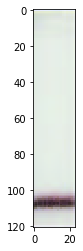

In [2]:
# read and plot original image
# image is in jpeg format because this is the starard format for android phones (and most mobile devices)

# read image using openCV
image_path = "lat_flow_images/paper_figure2_images/BKV_lat_flow_neg.jpg"
image_orig = cv2.imread(image_path)
pathogen_to_detect = "BKV"
image_orig_copy = image_orig.copy()
# display image using python function
implt(image_orig)


# these functions will display what openCV is seeing (the python function changes things a little bit)
# cv2.imshow("Original image", image_orig_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()



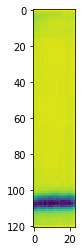

In [3]:
# convert image from BGR to RGB to 8-bit Grayscale
# Follows same preprocessing that Michael Kaminski uses
# could probably go BGR2GRAY -- kept it this way just to be safe
image_RBG = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
image_GRAY = cv2.cvtColor(image_RBG, cv2.COLOR_RGB2GRAY)
implt(image_GRAY)

# cv2.imshow("Grayscale image", image_GRAY)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

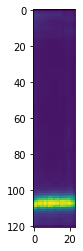

In [4]:
# invert image colors -- again, following what Prof. Kaminski does during signal quantification
image_invert = cv2.bitwise_not(image_GRAY)
implt(image_invert)

image_invert_orig = image_invert.copy() # saving original inverted image such that contour box is not saved over
# cv2.imshow("Inverted image", image_invert_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

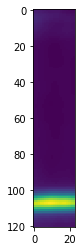

In [5]:
# apply Gaussian blur (helps with bright-spot detection)
image_blur = cv2.GaussianBlur(image_invert, (11, 11), 0)
implt(image_blur)

# cv2.imshow("Gaussian blur image", image_blur_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

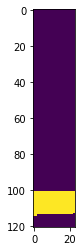

In [6]:
# apply threshold 
thresh = float(cv2.meanStdDev(image_blur)[0]) + 0.5*float(cv2.meanStdDev(image_blur)[1])
image_thresh = cv2.threshold(image_blur, thresh, 255, cv2.THRESH_BINARY)[1]
# image_thresh = cv2.adaptiveThreshold(image_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#             cv2.THRESH_BINARY,115,4)
implt(image_thresh)

# cv2.imshow("Threshold", image_thresh_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

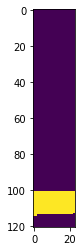

In [7]:
# Noise reduction by eroding and dialating 
# page 127 - 129(http://szeliski.org/Book/drafts/SzeliskiBook_20100903_draft.pdf)
# https://docs.opencv.org/2.4/doc/tutorials/imgproc/erosion_dilatation/erosion_dilatation.html

image_erode = cv2.erode(image_thresh, None, iterations=1)
image_no_noise = cv2.dilate(image_erode, None, iterations=1)
implt(image_no_noise)

# cv2.imshow("No noise", image_no_noise_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [8]:
# perform a connected component analysis on the thresholded image
# essentially, this helps identify the "largest blobs"
# https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/

labels = skimage.measure.label(image_no_noise, neighbors=8, background=0)
mask = np.zeros(image_no_noise.shape, dtype="uint8")
 
# loop over the unique components
for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue
 
    # otherwise, construct the label mask and count the
    # number of pixels 
    labelMask = np.zeros(image_no_noise.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
 
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 100:
        mask = cv2.add(mask, labelMask)


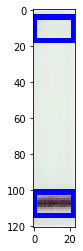

In [9]:
# find the contours in the mask, then sort them from bottom(control)-to-top(sample)

cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts, method="bottom-to-top")[0]

roi = []
x_list = []
y_list = []
width_list = []
height_list = []
# loop over the contours

if len(cnts) > 1:
    for (i, c) in enumerate(cnts):
        # draw the bright spot on the image
        # get the min area rect
        x, y, width, height = cv2.boundingRect(c)
        roi.append(image_invert_orig[y:y+height, x:x+width])
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        # convert all coordinates floating point values to int
        box = np.int0(box)
        # draw a red 'nghien' rectangle
        cv2.drawContours(image_orig, [box], 0, (0, 0, 255), thickness=2)
        
elif len(cnts) == 1:
    # draw the bright spot on the image
        # get the min area rect
        for (i, c) in enumerate(cnts):
            x, y, width, height = cv2.boundingRect(c)
            roi.append(image_invert_orig[y:y+height, x:x+width])
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            # convert all coordinates floating point values to int
            box = np.int0(box)
            # draw a red 'nghien' rectangle
            cv2.drawContours(image_orig, [box], 0, (0, 0, 255), thickness=2)
        
        if pathogen_to_detect == "CMV":
            roi_shift = np.int0(round(width*3.8)) 
        else:
            roi_shift = np.int0(round(width*4.2))

        roi.append(image_invert_orig[y-roi_shift:y+height-roi_shift, x:x+width])

        box[:,1] = box[:,1]-roi_shift
        cv2.drawContours(image_orig, [box], 0, (0, 0, 255), thickness=2)
        
else :
    print("Error. No bands located. Please retake photo.")




# # show the output image
# cv2.imshow("Image", image_invert_jpg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
implt(image_orig)

In [10]:
cv2.imwrite("BKV_lat_flow_neg.png",image_orig)

True

In [ ]:
# ratio sample to control
# if len(cnts) == 2:
ratio = float(cv2.meanStdDev(roi[1])[0] / cv2.meanStdDev(roi[0])[0])

thresh = 0.40 # Around threshold Michael uses (0.5)
if ratio > thresh:
    print("The sample band is POSITIVE (transplant rejection)")
else:
    print("The sample band is NEGATIVE (transplant accepted)")
ratio

In [ ]:
image_path

In [ ]:
implt(roi[0]) # control

In [ ]:
implt(roi[1]) #sample